In [1]:
# Import needed libraries
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

# Read Data
df = pd.read_csv('housing.csv')

# Take a look at the Data
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [3]:
# Explore the last column

df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

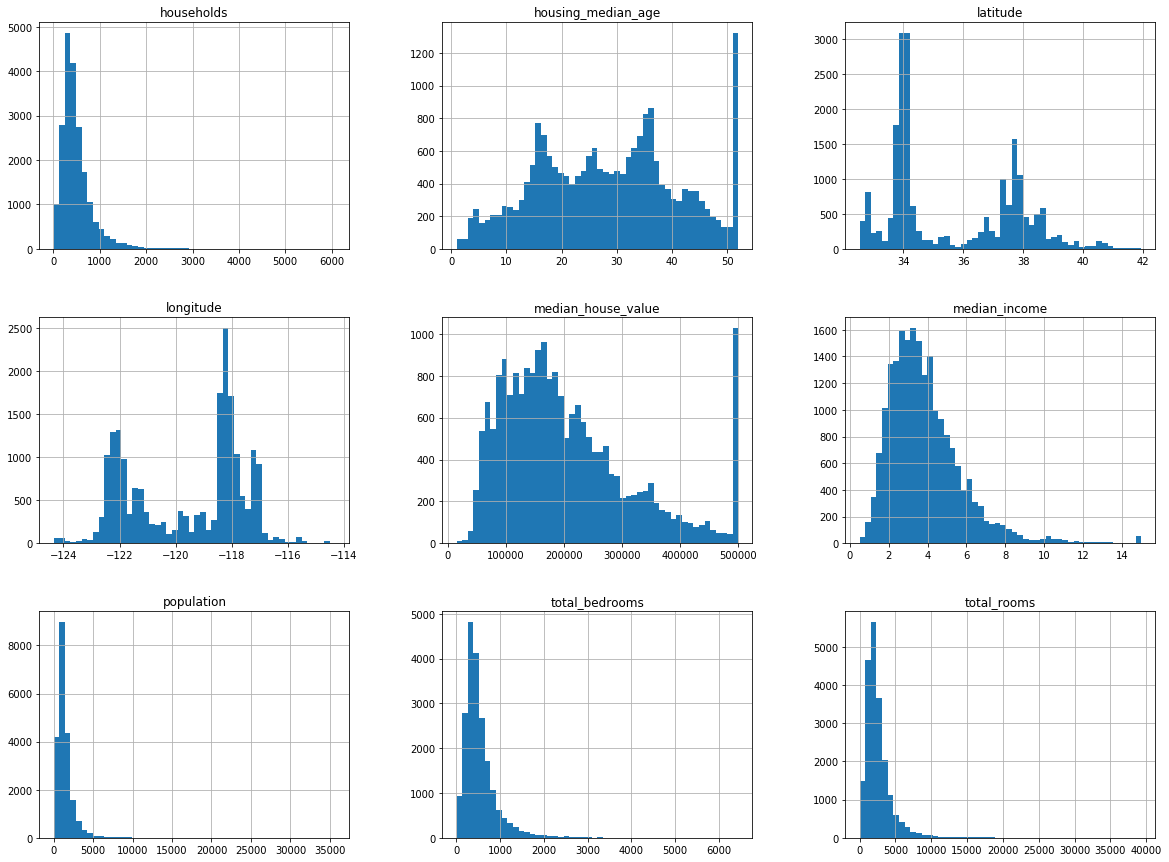

In [4]:
# Get a feel for the data

df.hist(bins=50, figsize=(20,15))
plt.show()

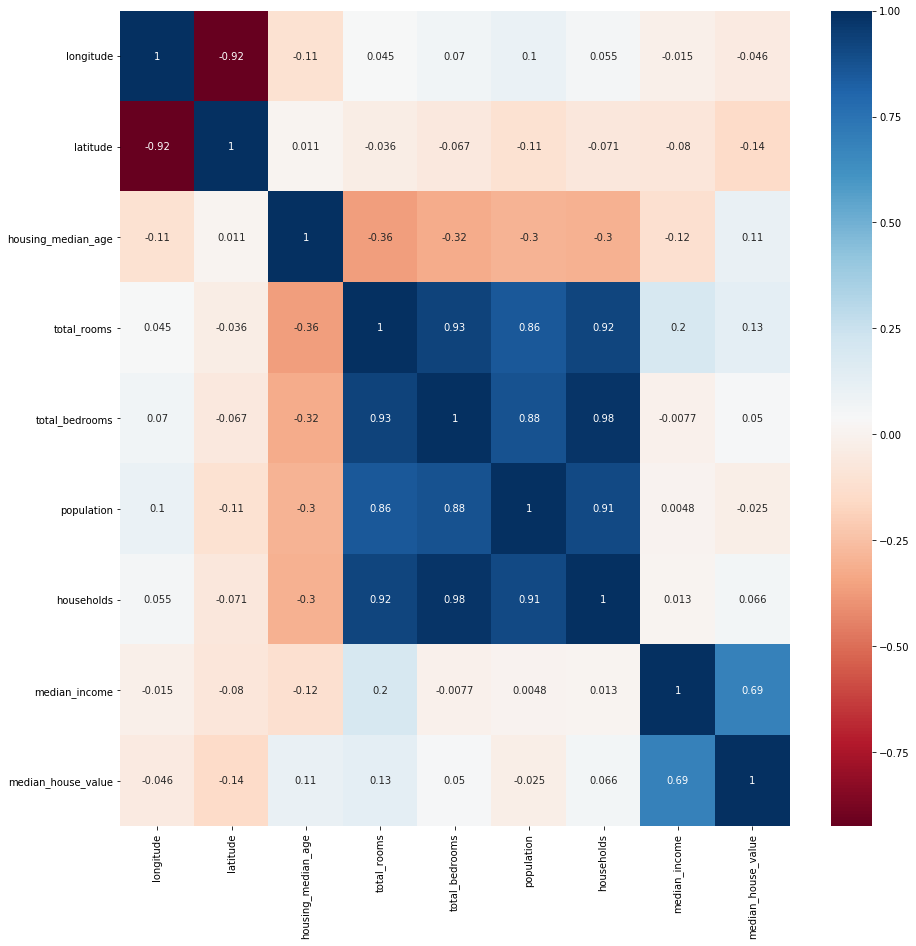

In [5]:
# Take a look at the correlations between the variables and our target variable(median_house_value)
corr = df.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(corr, annot = True, cmap = 'RdBu')

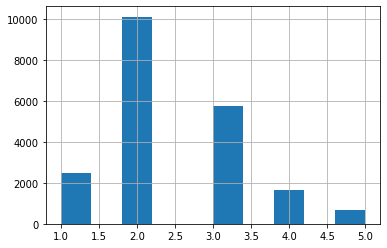

In [6]:
# Make a new feature, income_cat, that divides the median income into discrete categories

df["income_cat"] = pd.cut(df['median_income'], bins = [0, 2, 4, 6, 8, np.inf], labels = [1,2,3,4,5])
df["income_cat"].hist()

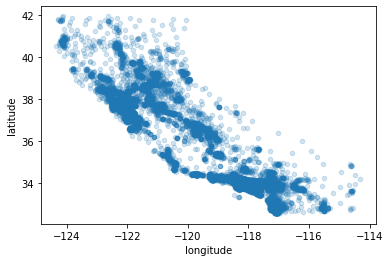

In [7]:
# Copy the set to not harm the original 

housing = df.copy()

# Visualize the geographical data

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.2)

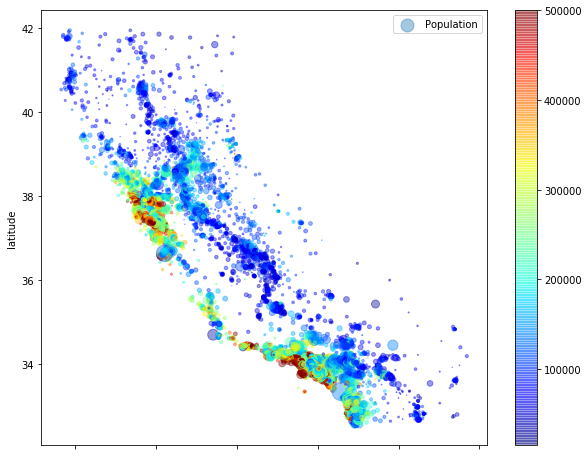

In [8]:
# Use a heat map to show the population density and the median price of houses together

housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, s = housing['population']/105,
             label = 'Population', figsize = (10, 8), c = housing['median_house_value'], cmap=plt.get_cmap("jet"),
             colorbar=True)
plt.legend()

# We can infer that the price is closely related with the population desity as well as the location(close to the ocean)

In [9]:
# Let's find out how each variable is correlated with the median house value

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013FB19A1608>,
      dtype=object)

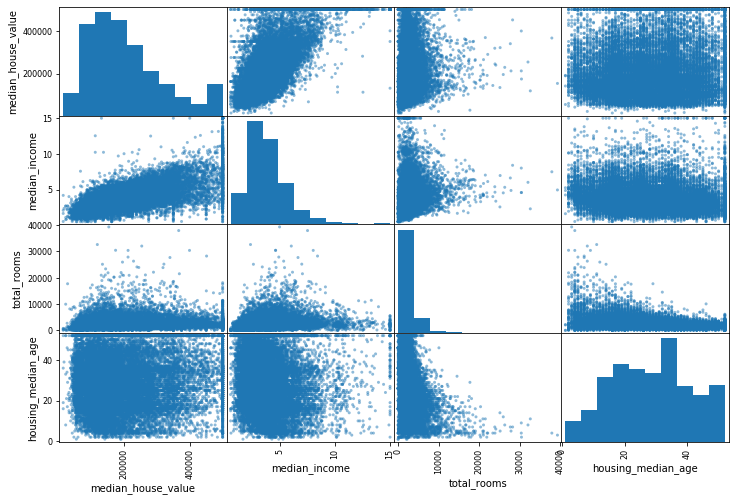

In [10]:
# Plot the relevant variables against each other

from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

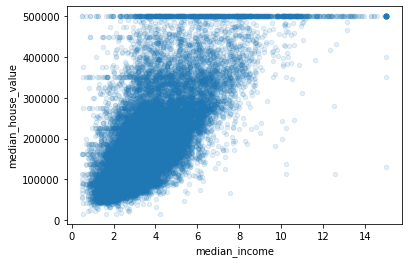

In [11]:
# Take a look at the most relevant variable

housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.12)

# Add some relevant features by trying out interesting attribute combinations


For example: bedrooms per room, rooms per household, and population per household, we will later add these using a pipeline

In [12]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [13]:
# Explore the correlations again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

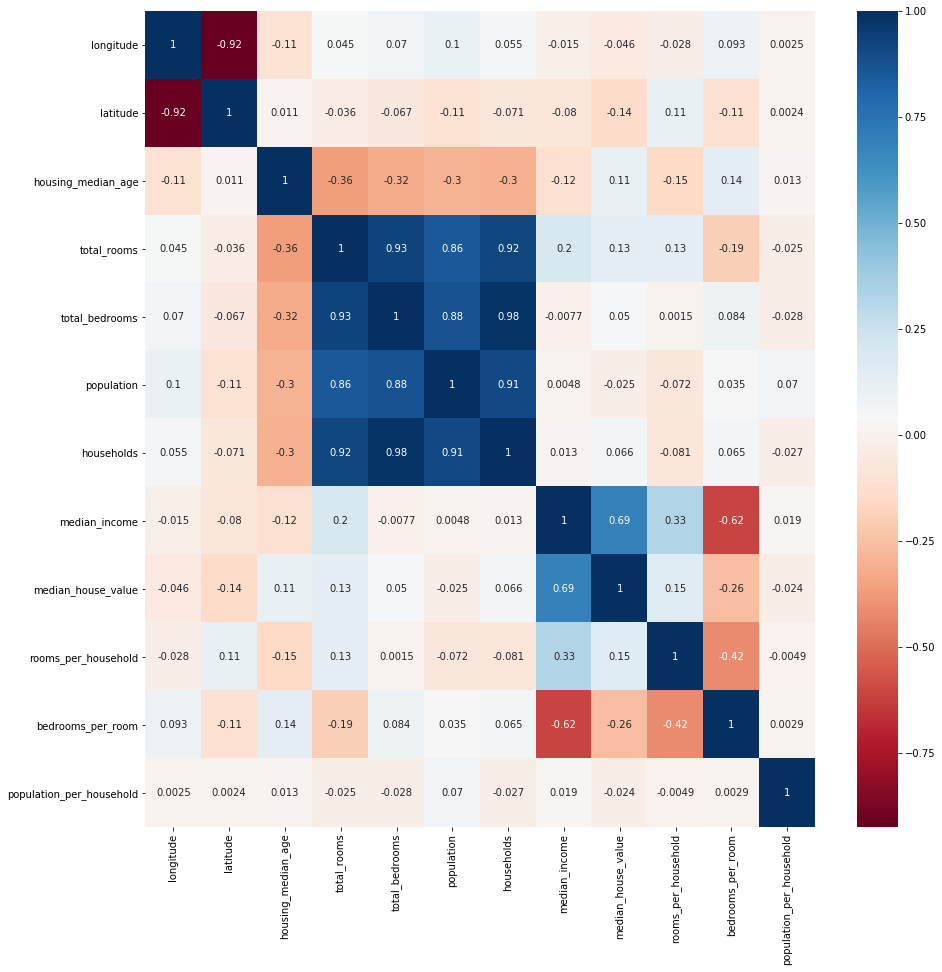

In [14]:
plt.figure(figsize = (15, 15))
sns.heatmap(corr_matrix, annot = True, cmap = 'RdBu')

In [15]:
housing.drop(["rooms_per_household", "bedrooms_per_room", "population_per_household"], axis = 1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,4
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,2
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,1


In [16]:
# Make a function that adds the attributes
from sklearn.preprocessing import FunctionTransformer
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [17]:
num_cols = housing.drop(['ocean_proximity', 'median_house_value', 'income_cat'], axis = 1).columns
housing_labels = housing['median_house_value']
housing_features = housing.drop(['median_house_value', 'income_cat'], axis = 1)

In [18]:
# Make a pipeline that cleans and preprocesses the numerical variables
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
        ])

In [19]:
# Do the same for the categorical variables then add both of the them and make a full pipeline
num_attribs = num_cols
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", OneHotEncoder(), cat_attribs),
])

In [20]:
housing_prepared = full_pipeline.fit_transform(housing_features)

In [21]:
y = housing_labels
X = housing_prepared
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = df['income_cat'])


In [22]:
''' A linear regression model wouldn't work here as it is not complex enough, so we will use an ensemble,
a random forest regressor '''
# use the gridsearchcv method to find the best hyperparameters, this will take quite some time
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [ 10, 30, 35], 'max_features': [4, 6, 8, 12]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [23]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 35}

In [24]:
# look at all the possible combinations
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

70689.23315352437 {'max_features': 4, 'n_estimators': 10}
68838.70561887398 {'max_features': 4, 'n_estimators': 30}
67556.55477023812 {'max_features': 4, 'n_estimators': 35}
69797.3764605508 {'max_features': 6, 'n_estimators': 10}
68796.77380467666 {'max_features': 6, 'n_estimators': 30}
67894.0184346939 {'max_features': 6, 'n_estimators': 35}
70557.77599480754 {'max_features': 8, 'n_estimators': 10}
68726.57899670526 {'max_features': 8, 'n_estimators': 30}
67757.4303763018 {'max_features': 8, 'n_estimators': 35}
70783.91769854329 {'max_features': 12, 'n_estimators': 10}
70514.6309368715 {'max_features': 12, 'n_estimators': 30}
69194.01429472741 {'max_features': 12, 'n_estimators': 35}
80350.42080520107 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
72016.94499739252 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
77809.37636013467 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
70198.97191814253 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [25]:
# Make our final model then check for its rmse and accuracy
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_mse)
print('Root mean squared error: ', final_rmse)
print('Accuracy : ', final_model.score(X_test, y_test))

409914716.0031884
Root mean squared error:  20246.350683596993
Accuracy :  0.9694003054135294


In [26]:
# look at the different variable's importance in relation to the evaluation
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.30000157e-02, 6.79489820e-02, 3.85392833e-02, 1.69647127e-02,
       1.61455271e-02, 1.70858906e-02, 1.67251390e-02, 2.66265079e-01,
       5.00368212e-02, 6.40856893e-02, 7.15065364e-02, 4.96930140e-02,
       6.08255665e-02, 4.15871618e-02, 2.17727151e-02, 1.11984666e-01,
       2.54632842e-04, 6.57549683e-03, 9.00307031e-03])

In [27]:
# Assign the different feature importance values to the corresponding features
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attribs = list(housing_features.columns) + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attribs), reverse=True)

[(0.2662650792585018, 'median_income'),
 (0.11198466616524692, '<1H OCEAN'),
 (0.07300001566949814, 'longitude'),
 (0.07150653636682283, 'bedrooms_per_room'),
 (0.0679489820332682, 'latitude'),
 (0.06408568925214317, 'rooms_per_household'),
 (0.06082556645332523, 'rooms_per_hhold'),
 (0.05003682123701418, 'ocean_proximity'),
 (0.04969301402181801, 'population_per_household'),
 (0.0415871617554221, 'pop_per_hhold'),
 (0.03853928331957196, 'housing_median_age'),
 (0.021772715068435918, 'bedrooms_per_room'),
 (0.01708589059242077, 'population'),
 (0.01696471271367677, 'total_rooms'),
 (0.016725139040414092, 'households'),
 (0.016145527067899013, 'total_bedrooms'),
 (0.009003070313651386, 'NEAR BAY'),
 (0.00657549682915775, 'ISLAND'),
 (0.00025463284171183307, 'INLAND')]

In [28]:
'''As we cannot be sure our model would have the same rmse and accuracy, let's calculate the 95% confidence
interval'''
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc = squared_errors.mean(),
scale = stats.sem(squared_errors)))


array([19095.92011482, 21334.8369334 ])